# <center> BÀI THI NHÓM FINSIGHT - ATTACKER 2024

# 1. BỘ LỌC DỮ LIỆU

### Import thư viện

In [82]:
from vnstock import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ffn
import bt
%matplotlib inline

### Lấy dữ liệu và lọc

In [83]:
# Define parameters for stock screening insights
params = {"exchangeName": "HOSE,HNX,UPCOM"}

# Get stock screening insights data
df = stock_screening_insights(params, size=1700, drop_lang='vi')

# Merge with listing companies data
listing_df = listing_companies()
df = df.merge(listing_df, how='left', on='ticker')

# Filter for stocks in VN30 index
df = df[df['VN30']==True]

# Filter for stocks meeting conditions: Price above SMA(50), Price above SMA(100), rsi14 between 30 and 75
df = df[(df['priceVsSma50.en'] == 'Price above SMA(50)') & (df['priceVsSMA100.en'] == 'Price above SMA(100)')]

# Fill NaN values in 'evEbitda' column with 0
df['evEbitda'].fillna(0, inplace=True)

# Filter for stocks meeting additional conditions: epsGrowth5Year > 0, revenueGrowth5Year > 0,
# pe < 20, marketCap < 300000, rsi14 between 30 and 75, evEbitda >= 0, and financialHealth > 3.0
df = df[(df['epsGrowth5Year'] > 0) & (df['revenueGrowth5Year'] > 0) & (df['pe'] < 20) &
        (df['marketCap'] < 300000) & (df['rsi14'] >= 30) & (df['rsi14'] <= 75) & (df['evEbitda'] >= 0) &
        (df['financialHealth'] > 3.0)]

# Display the filtered DataFrame
df

,ticker,companyName,marketCap,roe,stockRating,businessOperation,businessModel,financialHealth,alpha,beta,...,VNCOND,VNCONS,VNENE,VNFIN,VNHEAL,VNIND,VNIT,VNMAT,VNREAL,VNUTI
12,ACB,,105064.0,24.8,3.0,4.3,3.6,3.6,0.1,0.8,...,False,False,False,True,False,False,False,False,False,False
102,BID,,291292.0,19.8,3.0,3.3,4.3,3.6,0.1,1.0,...,False,False,False,True,False,False,False,False,False,False
277,CTG,,185265.0,17.1,3.1,3.6,4.5,3.6,0.1,0.9,...,False,False,False,True,False,False,False,False,False,False
801,MBB,,123052.0,24.5,3.5,4.7,4.5,3.4,0.1,0.9,...,False,False,False,True,False,False,False,False,False,False
1296,TCB,,144423.0,14.8,3.4,4.3,3.4,3.6,0.1,1.1,...,False,False,False,True,False,False,False,False,False,False
1580,VRE,,57717.0,12.4,3.0,3.1,4.3,5.0,-0.1,1.2,...,False,False,False,False,False,False,False,False,True,False


### Phân tích từng cổ phiếu

In [84]:
stock_ls_analysis("ACB, CTG, MBB, VHM, VRE")

Mã CP,ACB,CTG,MBB,VHM,VRE
Vốn hóa (tỷ),105064,185265,123052,185278,57717
Giá,27050,34500,23600,42550,25400
Số phiên tăng/giảm liên tiếp,-3,-3,-2,-1,-1
P/E,6.5,9.3,6.0,5.6,13.1
PEG,0.4,0.5,0.3,0.4,0.2
P/B,1.5,1.5,1.3,1.0,1.5
Cổ tức,0.0,0.0,0.0,0.0,0.0
ROE,0.248,0.171,0.245,0.205,0.124
ROA,0.024,0.01,0.025,0.082,0.098
Nợ/Vốn CSH,9.1,14.9,8.8,0.3,0.1


# 2. SMA Strategy

### Lấy dữ liệu từ file BTC và làm sạch

In [85]:
file_names = ["ACB.csv", "CTG.csv", "MBB.csv"]

# List to store individual DataFrames
data = []

# Read each CSV file, set 'Date' column as index, and rename 'Close' column
for file_name in file_names:
    df = pd.read_csv(file_name)
    df['Date'] = pd.to_datetime(df['Date'])  # Convert 'Date' column to DateTime format
    df.set_index('Date', inplace=True)  # Set 'Date' column as index
    df.rename(columns={'Close': file_name[:-4]}, inplace=True)  # Rename 'Close' column
    data.append(df)

# Merge all DataFrames on their indices
merged_df = pd.concat(data, axis=1)

# Select rows starting from 1-1-2018 and keep only the 'Close' column
data = merged_df.loc['2020-04-01':, ['ACB', 'CTG', 'MBB']]  # Adjust column names if needed
data = data.dropna()

#Display
data

,ACB,CTG,MBB
Date,,,
2020-04-01,7.649678,12.21324,6.502916
2020-04-03,7.855314,12.54693,6.731089
2020-04-06,8.472224,13.41454,7.187434
2020-04-07,8.348842,13.24769,7.278703
2020-04-08,8.307714,13.14758,7.164617
...,...,...,...
2024-01-26,26.300000,32.10000,22.000000
2024-01-29,25.950000,32.30000,22.150000
2024-01-30,25.950000,32.20000,22.100000


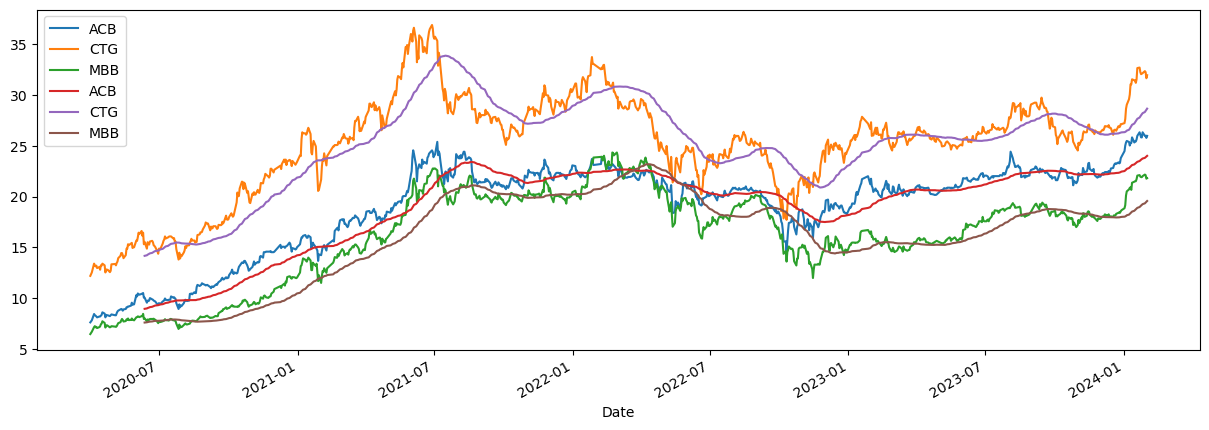

In [86]:
sma = data.rolling(50).mean()

plot = bt.merge(data, sma).plot(figsize=(15, 5))

In [96]:
class SelectWhere(bt.Algo):
    def __init__(self, signal):
        self.signal = signal

    def __call__(self, target):
        # get signal on target.now
        if target.now in self.signal.index:
            sig = self.signal.loc[target.now]

            # get indices where true as list
            selected = list(sig.index[sig])

            # save in temp - this will be used by the weighing algo
            target.temp['selected'] = selected

        # return True because we want to keep on moving down the stack
        return True

In [97]:
signal = data > sma

Stat                 above50sma
-------------------  ------------
Start                2020-03-31
End                  2024-02-01
Risk-free rate       0.00%

Total Return         54.51%
Daily Sharpe         0.60
Daily Sortino        0.89
CAGR                 12.00%
Max Drawdown         -46.93%
Calmar Ratio         0.26

MTD                  0.65%
3m                   13.58%
6m                   6.23%
YTD                  14.39%
1Y                   15.55%
3Y (ann.)            8.88%
5Y (ann.)            12.00%
10Y (ann.)           -
Since Incep. (ann.)  12.00%

Daily Sharpe         0.60
Daily Sortino        0.89
Daily Mean (ann.)    14.27%
Daily Vol (ann.)     23.73%
Daily Skew           -0.73
Daily Kurt           4.54
Best Day             5.86%
Worst Day            -6.95%

Monthly Sharpe       0.55
Monthly Sortino      1.11
Monthly Mean (ann.)  14.48%
Monthly Vol (ann.)   26.43%
Monthly Skew         0.54
Monthly Kurt         0.98
Best Month           25.08%
Worst Month          -14.06%

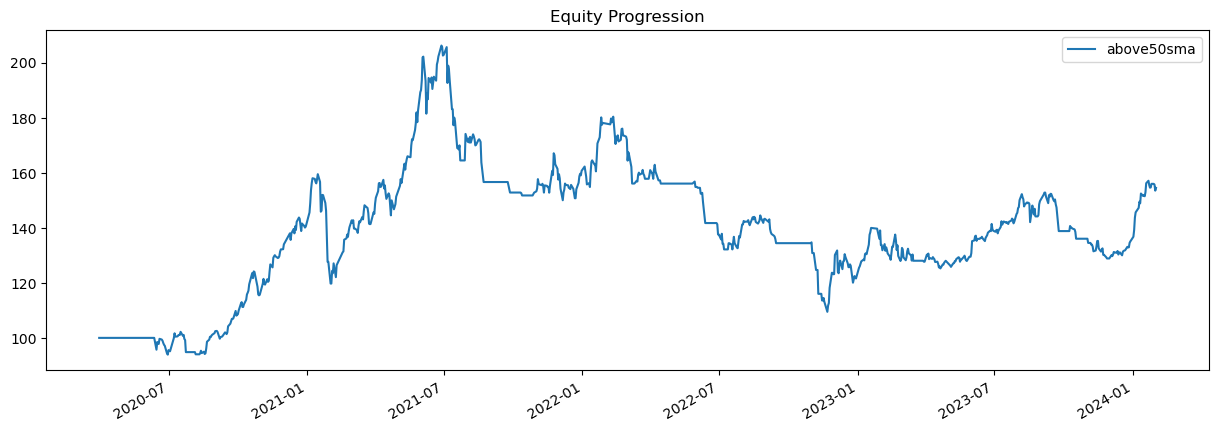

In [98]:
s = bt.Strategy('above50sma', [SelectWhere(data > sma),
                               bt.algos.WeighEqually(),
                               bt.algos.Rebalance()])

# now we create the Backtest
t = bt.Backtest(s, data)

# and let's run it!
res = bt.run(t)
res.plot();
res.display()

# 3. SMA Crossover Strategy

In [33]:
class WeighTarget(bt.Algo):
    def __init__(self, target_weights):
        self.tw = target_weights

    def __call__(self, target):
        # get target weights on date target.now
        if target.now in self.tw.index:
            w = self.tw.loc[target.now]

            # save in temp - this will be used by the weighing algo
            # also dropping any na's just in case they pop up
            target.temp['weights'] = w.dropna()

        # return True because we want to keep on moving down the stack
        return True

In [49]:
sma50 = data.rolling(10).mean()
sma200 = data.rolling(200).mean()

In [50]:
## now we need to calculate our target weight DataFrame
# first we will copy the sma200 DataFrame since our weights will have the same strucutre
tw = sma200.copy()
# set appropriate target weights
tw[sma50 > sma200] = 1.0
tw[sma50 <= sma200] = -1.0
# here we will set the weight to 0 - this is because the sma200 needs 200 data points before
# calculating its first point. Therefore, it will start with a bunch of nulls (NaNs).
tw[sma200.isnull()] = 0.0

Stat                 ma_cross
-------------------  ----------
Start                2020-03-31
End                  2024-02-01
Risk-free rate       0.00%

Total Return         138.73%
Daily Sharpe         0.68
Daily Sortino        1.06
CAGR                 25.44%
Max Drawdown         -68.93%
Calmar Ratio         0.37

MTD                  1.96%
3m                   61.09%
6m                   42.01%
YTD                  48.11%
1Y                   90.42%
3Y (ann.)            47.30%
5Y (ann.)            25.44%
10Y (ann.)           -
Since Incep. (ann.)  25.44%

Daily Sharpe         0.68
Daily Sortino        1.06
Daily Mean (ann.)    49.58%
Daily Vol (ann.)     72.60%
Daily Skew           -0.23
Daily Kurt           5.74
Best Day             19.88%
Worst Day            -20.69%

Monthly Sharpe       0.59
Monthly Sortino      1.83
Monthly Mean (ann.)  46.24%
Monthly Vol (ann.)   78.96%
Monthly Skew         2.17
Monthly Kurt         5.70
Best Month           91.82%
Worst Month          -27.67

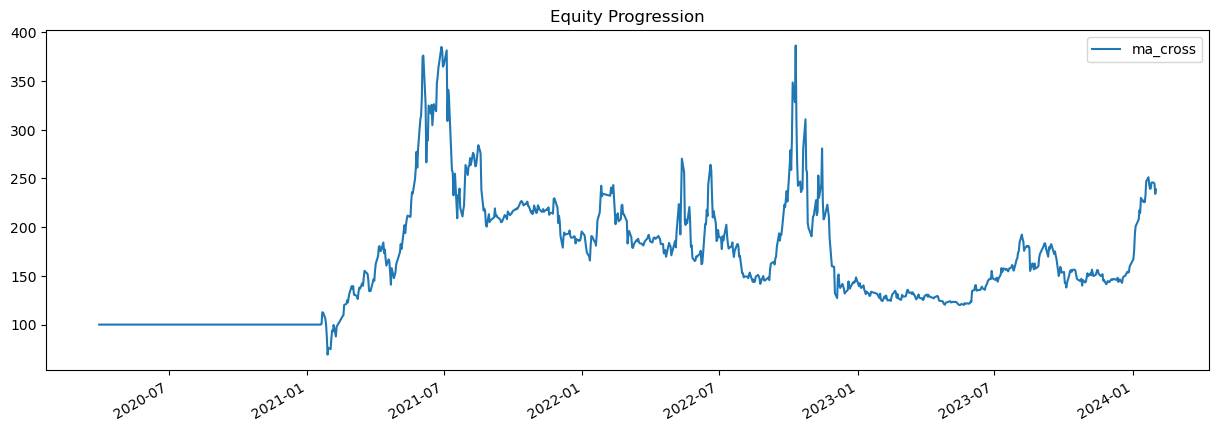

In [51]:
# Strategy
ma_cross = bt.Strategy('ma_cross', [WeighTarget(tw),
                                    bt.algos.Rebalance()])
# Backtest and Display
t = bt.Backtest(ma_cross, data)
res = bt.run(t)
res.plot();
res.display()

# 4. Buy and Hold Strategy

In [52]:
# algo to fire on the beginning of every month and to run on the first date
runMonthlyAlgo = bt.algos.RunMonthly(
    run_on_first_date=True
)

# algo to set the weights
#  it will only run when runMonthlyAlgo returns true
#  which only happens on the first of every month
weights = pd.Series([0.3, 0.4, 0.3],index = data.columns)
weighSpecifiedAlgo = bt.algos.WeighSpecified(**weights)

# algo to rebalance the current weights to weights set by weighSpecified
#  will only run when weighSpecifiedAlgo returns true
#  which happens every time it runs
rebalAlgo = bt.algos.Rebalance()

Stat                 static
-------------------  ----------
Start                2020-03-31
End                  2024-02-01
Risk-free rate       0.00%

Total Return         212.91%
Daily Sharpe         1.16
Daily Sortino        1.84
CAGR                 34.61%
Max Drawdown         -44.29%
Calmar Ratio         0.78

MTD                  0.68%
3m                   26.27%
6m                   16.04%
YTD                  14.78%
1Y                   27.45%
3Y (ann.)            20.13%
5Y (ann.)            34.61%
10Y (ann.)           -
Since Incep. (ann.)  34.61%

Daily Sharpe         1.16
Daily Sortino        1.84
Daily Mean (ann.)    34.42%
Daily Vol (ann.)     29.71%
Daily Skew           -0.44
Daily Kurt           2.63
Best Day             7.15%
Worst Day            -6.91%

Monthly Sharpe       1.16
Monthly Sortino      2.81
Monthly Mean (ann.)  33.36%
Monthly Vol (ann.)   28.79%
Monthly Skew         0.50
Monthly Kurt         0.51
Best Month           25.40%
Worst Month          -14.87%

Y

<Axes: title={'center': 'Equity Progression'}>

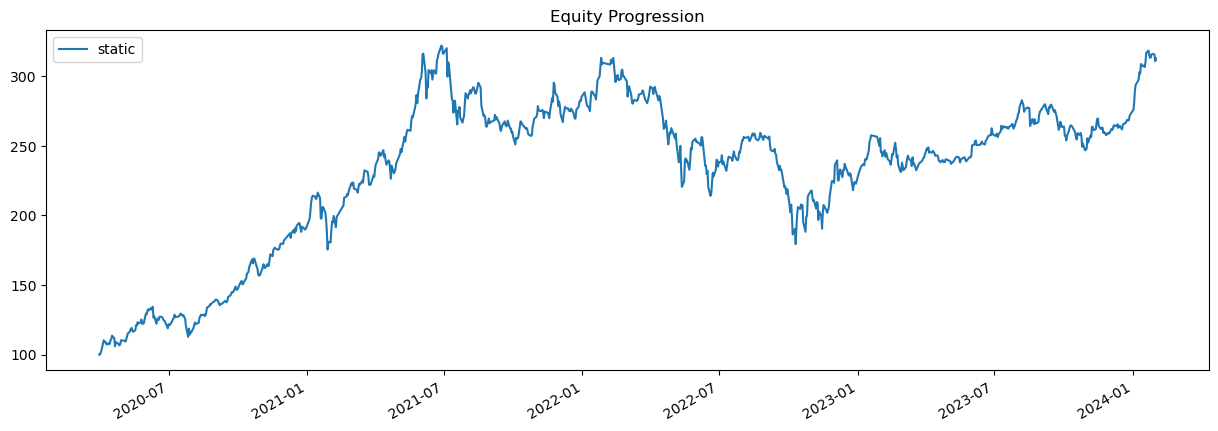

In [53]:
# a strategy that rebalances monthly to specified weights
strat = bt.Strategy('static',
    [
        runMonthlyAlgo,
        weighSpecifiedAlgo,
        rebalAlgo
    ]
)
# set integer_positions=False when positions are not required to be integers(round numbers)
backtest = bt.Backtest(
    strat,
    data,
    integer_positions=False
)

res = bt.run(backtest)
res.stats
res.display()
res.plot()

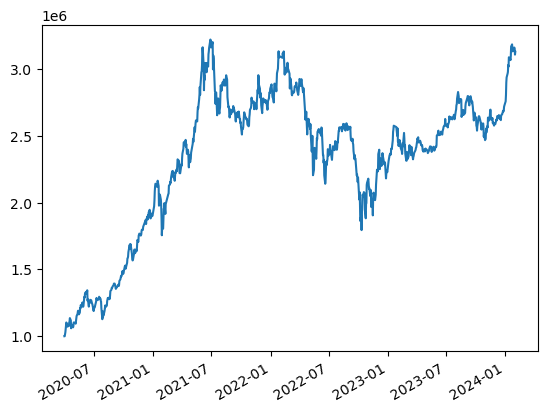

In [54]:
performanceStats = res['static']
#performance stats is an ffn object
res.backtest_list[0].strategy.values.plot();

# 5.Strategy Combination
- creates a parent strategy(combined) with 2 child strategies(Equal Weight, Inv Vol).
- Alternatively, it creates the 2 child strategies, runs the backtest, combines the results, and creates a parent strategy using both of the backtests.

In [77]:
strategy_names = np.array(
    [
        'Equal Weight',
        'Inv Vol'
    ]
)

runMonthlyAlgo = bt.algos.RunMonthly(
    run_on_first_date=True,
    run_on_end_of_period=True
)
selectAllAlgo = bt.algos.SelectAll()
rebalanceAlgo = bt.algos.Rebalance()

strats = []
tests = []

for i,s in enumerate(strategy_names):
    if s == "Equal Weight":
        wAlgo = bt.algos.WeighEqually()
    elif s == "Inv Vol":
        wAlgo = bt.algos.WeighInvVol()

    strat = bt.Strategy(
        str(s),
        [
            runMonthlyAlgo,
            selectAllAlgo,
            wAlgo,
            rebalanceAlgo
        ]
    )
    strats.append(strat)

    t = bt.Backtest(
        strat,
        pdf,
        integer_positions = False,
        progress_bar=False
    )
    tests.append(t)

In [78]:
combined_strategy = bt.Strategy(
    'Combined',
    algos = [
        runMonthlyAlgo,
        selectAllAlgo,
        bt.algos.WeighEqually(),
        rebalanceAlgo
    ],
    children = [x.strategy for x in tests]
)

combined_test = bt.Backtest(
    combined_strategy,
    data,
    integer_positions = False,
    progress_bar = False
)

res = bt.run(combined_test)

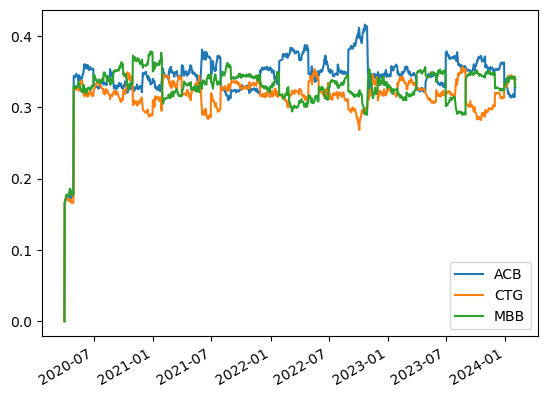

In [79]:
res.get_security_weights().plot();

In [80]:
res.display()

Stat                 Combined
-------------------  ----------
Start                2020-03-31
End                  2024-02-01
Risk-free rate       0.00%

Total Return         207.71%
Daily Sharpe         1.17
Daily Sortino        1.84
CAGR                 34.02%
Max Drawdown         -43.31%
Calmar Ratio         0.79

MTD                  0.65%
3m                   25.63%
6m                   16.18%
YTD                  14.39%
1Y                   28.34%
3Y (ann.)            21.13%
5Y (ann.)            34.02%
10Y (ann.)           -
Since Incep. (ann.)  34.02%

Daily Sharpe         1.17
Daily Sortino        1.84
Daily Mean (ann.)    33.76%
Daily Vol (ann.)     28.95%
Daily Skew           -0.49
Daily Kurt           2.74
Best Day             6.84%
Worst Day            -6.90%

Monthly Sharpe       1.17
Monthly Sortino      2.91
Monthly Mean (ann.)  32.69%
Monthly Vol (ann.)   27.95%
Monthly Skew         0.58
Monthly Kurt         0.61
Best Month           24.73%
Worst Month          -14.18%


<Axes: title={'center': 'Equity Progression'}>

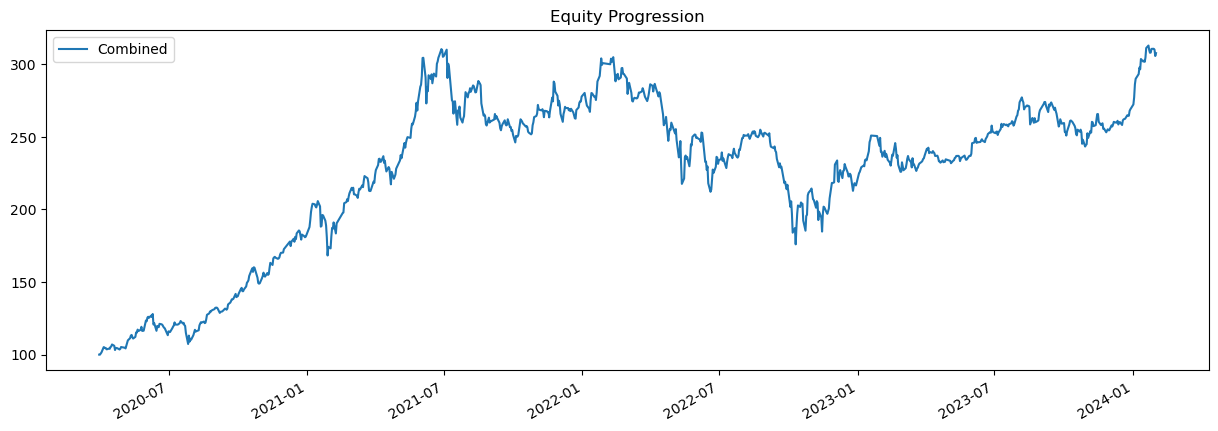

In [81]:
res.plot()